# Explore and clean text

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick
import seaborn as sns

from nltk import FreqDist

import sys
sys.path.append("../")

from src.preprocessing import preprocess_text

In [8]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')

print('train ->', train.shape)
print('test ->', test.shape)

train -> (7613, 5)
test -> (3263, 4)


In [9]:
train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [10]:
train.target.describe()

count    7613.00000
mean        0.42966
std         0.49506
min         0.00000
25%         0.00000
50%         0.00000
75%         1.00000
max         1.00000
Name: target, dtype: float64

In [11]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Let's look at keywords

In [12]:
train['keyword'].value_counts( normalize=True)[:10]

fatalities     0.005959
deluge         0.005561
armageddon     0.005561
sinking        0.005429
damage         0.005429
harm           0.005429
body%20bags    0.005429
outbreak       0.005297
evacuate       0.005297
fear           0.005297
Name: keyword, dtype: float64

<AxesSubplot: xlabel='keyword'>

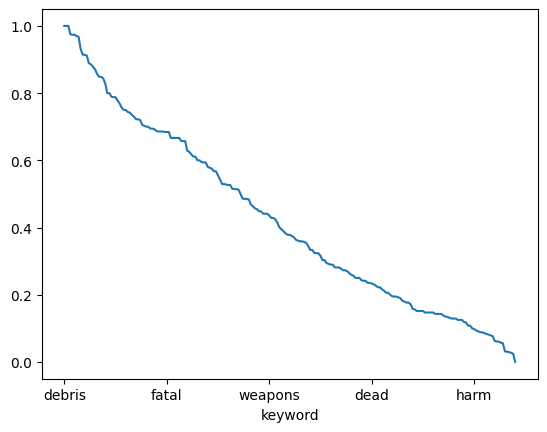

In [13]:
summary = train.groupby('keyword').agg(
    {'target': 'sum', 'keyword': 'count'}
).rename(
    columns={'target': 'disasters', 'keyword': 'base'}
)

summary['disaster_pct'] = summary['disasters'] / summary['base'] 

sorted_keywords = summary.sort_values(by='disaster_pct', ascending=False)['disaster_pct']

sorted_keywords.plot()

In [14]:
sorted_keywords[:25]

keyword
debris                   1.000000
wreckage                 1.000000
derailment               1.000000
outbreak                 0.975000
oil%20spill              0.973684
typhoon                  0.973684
suicide%20bombing        0.969697
suicide%20bomber         0.967742
bombing                  0.931034
rescuers                 0.914286
suicide%20bomb           0.914286
nuclear%20disaster       0.911765
evacuated                0.888889
razed                    0.885714
wildfire                 0.878788
wild%20fires             0.870968
airplane%20accident      0.857143
mass%20murder            0.848485
buildings%20on%20fire    0.848485
forest%20fires           0.843750
bridge%20collapse        0.828571
casualties               0.800000
drought                  0.800000
forest%20fire            0.789474
violent%20storm          0.787879
Name: disaster_pct, dtype: float64

And at location.

<AxesSubplot: >

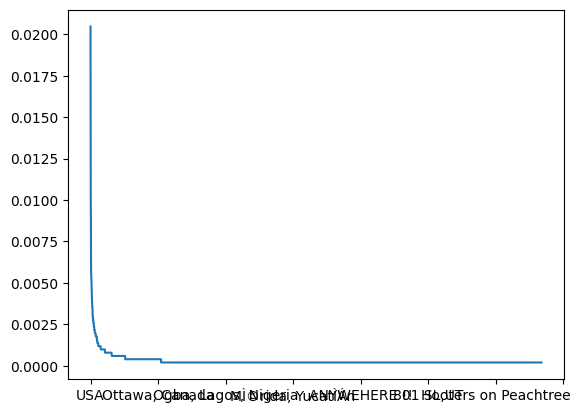

In [15]:
train['location'].value_counts(normalize=True).plot()

Let's quickly submit a base model based only in keywords.

In [16]:
summary['target'] = np.where(summary['disaster_pct'] > .5, 1, 0)
keyword_mapping = summary['target'].to_dict()

In [17]:
test['target'] = test['keyword'].map(keyword_mapping)
test['target'].fillna(0, inplace=True)
test['target'] = test['target'].astype(int)
test['target'].describe()

count    3263.000000
mean        0.376034
std         0.484463
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: target, dtype: float64

In [18]:
submission_set = test[['id', 'target']]

In [19]:
# submission_set.to_csv('../data/submissions/01-base-keyword-model.csv', index=False)

In [20]:
# !kaggle competitions submit -c nlp-getting-started -f ../data/submissions/01-base-keyword-model.csv -m "base keyword model"

## Clean text

In [30]:
text = train.loc[2, 'text']
print('text:', text)
print('preprocessed text:', preprocess_text(text))

text: All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
preprocessed text: resident asked place notified officer evacuation shelter place order expected


In [52]:
train['clean_text'] = train['text'].apply(preprocess_text)
train.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/neperiana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/neperiana/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident asked place notified officer evacuati...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfire pour...


In [53]:
all_the_text = ' '.join(train['clean_text'].values.flatten())
all_the_tokens = all_the_text.split(" ")

In [54]:
# Extract word frequency and sort
token_distr = pd.Series(
    dict(FreqDist(all_the_tokens))
).sort_values(ascending=False)

# Identify top 5 words
print(token_distr[:10])

X       1536
wa       408
fire     349
like     348
ha       269
get      254
new      223
via      218
u        205
one      204
dtype: int64


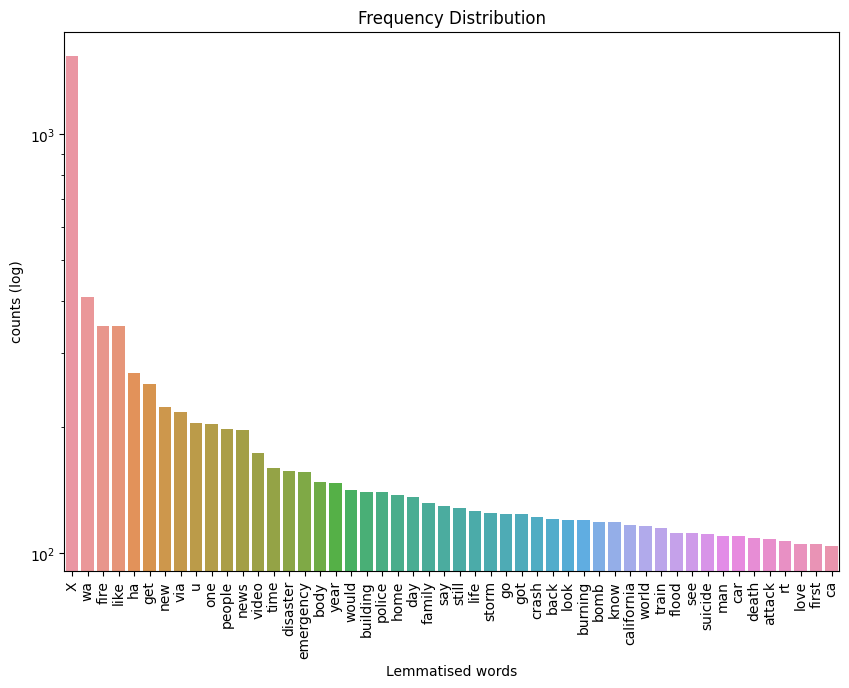

In [57]:
# Extracting top 20 words and plotting
top20_tokens = token_distr[:50]

# set up plots
fig, ax = plt.subplots(figsize=(10,7))

# plot distribution 
bars = sns.barplot(
    x=top20_tokens.index, 
    y=top20_tokens.values, 
    ax=ax,
)

# labels and titles
plt.xticks(rotation=90)
ax.set_yscale('log')
bars.set(xlabel='Lemmatised words', ylabel='counts (log)', title='Frequency Distribution')

plt.show()